## Unsupervised Learning and Data Exploration to Predict Gallery Tier
### First step towards building an objective Gallery Qualification Score
**Author: Nicholas Sewitz  
Contributors: Anil Bawa-Cavia, Will Goldstein**

This notebook processes certain predetermined features that we believe are predictive of the qualitative gallery tier score applied by the GFI team. The goal is to identify what features and models should be used to build a more ambitious objective qualification score.

In [1]:
import sys, os
import datetime
sys.path.append(os.environ['minotaur'])

import os.path
import http
import urllib.request 
from urllib.request import urlopen
from bs4 import BeautifulSoup
from socket import timeout
import boto3
import gzip
import io


from __future__ import print_function

from pprint import pprint
from time import time
import logging


import yaml

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 14,3

from dbs import redshift
redshift.connect()

from __future__ import division

from pygeocoder import Geocoder
from geopy.distance import vincenty

from slugify import slugify

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from gensim.models import doc2vec
from collections import namedtuple


#### Run Wrangling Script

In [6]:
%run ./data_wrangling_to_predict_qualification.py

#### Data Exploration

In [2]:
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x

# get your credentials from environment variables
aws_id = os.environ['AWS_ID']
aws_secret = os.environ['AWS_SECRET']

s3 = boto3.client('s3', aws_access_key_id=aws_id,
        aws_secret_access_key=aws_secret)

bucket_name = 'artsy-data'


In [3]:
object_key = 'temp/df_with_less_text.csv'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df_with_less_text = pd.read_csv(StringIO(csv_string))
del df_with_less_text['Unnamed: 0']


In [4]:
object_key = 'temp/df_with_many_text.csv'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df_with_many_text = pd.read_csv(StringIO(csv_string))
del df_with_many_text['Unnamed: 0']

In [5]:
df = df_with_less_text.copy()
df.reset_index(inplace=True,drop=True)

del df['inquiry_requests_count']
del df['bid_count']
del df['disqualified_reason']
del df['Clicks']
del df['Impressions']
del df['is_closed']
del df['text_parse']

str_cols = ['on_artsy','artist_slug','search_volume']
df[str_cols] = df[str_cols].fillna(0)

In [6]:
df.head()

,domain,gallery_tier,on_artsy,search_volume,artist_slug,min_distance_to_art_city,partner_on_artsy,qualified
0,tattoo-icons.com,0,0.0,0.0,4.0,NaN,False,not_qualified
1,Maningrida.com,50,0.0,0.0,0.0,2651.170673,False,qualified
2,frascionearte.com,50,0.0,0.0,0.0,NaN,False,qualified
3,thehearlegallery.com,0,0.0,110.0,21.0,3275.942567,False,not_qualified
4,artisse.it,50,0.0,0.0,0.0,NaN,False,qualified


In [8]:
df.groupby(['qualified']).count()

,domain,gallery_tier,on_artsy,search_volume,artist_slug,min_distance_to_art_city,partner_on_artsy
qualified,,,,,,,
not_qualified,3180,3181,3181,3181,3181,718,3181
qualified,97283,97283,97283,97283,97283,29621,97283
very_qualified,1652,1652,1652,1652,1652,863,1652


In [9]:
del df['domain']

df = df.dropna()

In [10]:
df.columns

Index(['gallery_tier', 'on_artsy', 'search_volume', 'artist_slug',
       'min_distance_to_art_city', 'partner_on_artsy', 'qualified'],
      dtype='object')

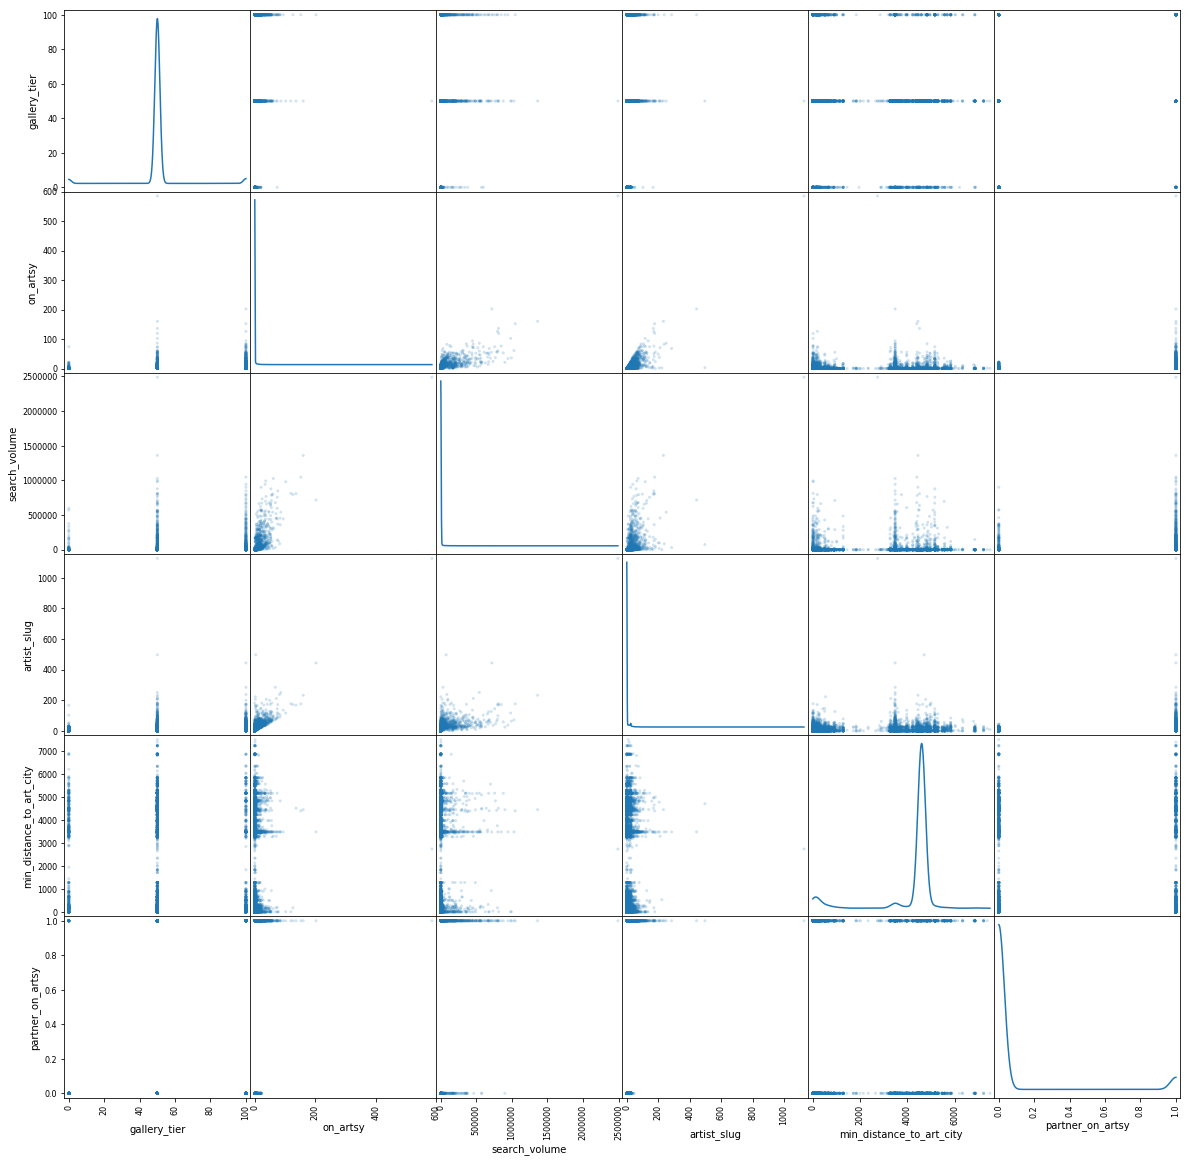

In [11]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

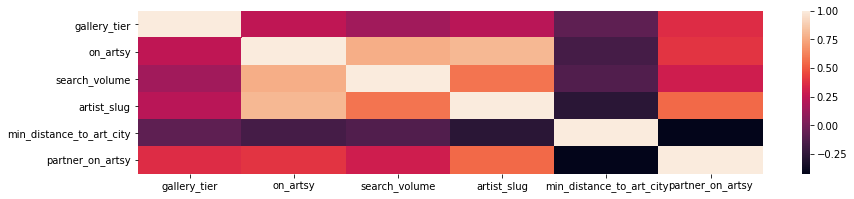

In [12]:
#looks like we might be getting skewed data for galleries that have a lot of artists on artsy. 
#Can we assume these are also galleries on Artsy?
corr = df.corr()

sns.heatmap(corr)


In [13]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,gallery_tier,on_artsy,search_volume,artist_slug,min_distance_to_art_city,partner_on_artsy
gallery_tier,1,0.24,0.15,0.22,-0.08,0.37
on_artsy,0.24,1,0.77,0.81,-0.16,0.39
search_volume,0.15,0.77,1,0.58,-0.12,0.3
artist_slug,0.22,0.81,0.58,1,-0.27,0.55
min_distance_to_art_city,-0.08,-0.16,-0.12,-0.27,1,-0.43
partner_on_artsy,0.37,0.39,0.3,0.55,-0.43,1


#### Unsupervised Learning Exploration

In [14]:


df.dropna().shape, df.shape

((31202, 7), (31202, 7))

In [15]:
df.groupby('qualified').count()

,gallery_tier,on_artsy,search_volume,artist_slug,min_distance_to_art_city,partner_on_artsy
qualified,,,,,,
not_qualified,718,718,718,718,718,718
qualified,29621,29621,29621,29621,29621,29621
very_qualified,863,863,863,863,863,863


In [16]:
X = df.copy()
y = X['qualified']
del X['qualified']
del X['gallery_tier']
print(X.columns)
X = X.values


Index(['on_artsy', 'search_volume', 'artist_slug', 'min_distance_to_art_city',
       'partner_on_artsy'],
      dtype='object')


#### KMeans Clustering

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


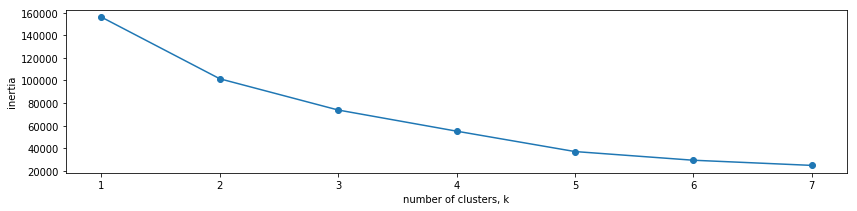

In [17]:
ks = range(1, 8)
inertias = []

scaler = StandardScaler()
X = scaler.fit_transform(X)
    
for k in ks:
    # Create scaler: scaler


    # Create KMeans instance: kmeans
    kmeans = KMeans(n_clusters=k)

    # Create pipeline: pipeline
    
    # Fit model to samples
    kmeans.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()



In [18]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(X)

# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Create a DataFrame with labels and tier as columns: df
dfl = pd.DataFrame({'labels': labels, 'qualified': y})

# Create crosstab: ct
ct = pd.crosstab(dfl['labels'], y)

# Display ct
print(ct)

# average of every feature for each clsuter, concat and group by avrage
# may need to visualize feature by feature


qualified  not_qualified  qualified  very_qualified
labels                                             
0                    337      26921              52
1                      4         84              91
2                    342       1297             112
3                     35       1319             608


#### Heirarchical Clustering

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


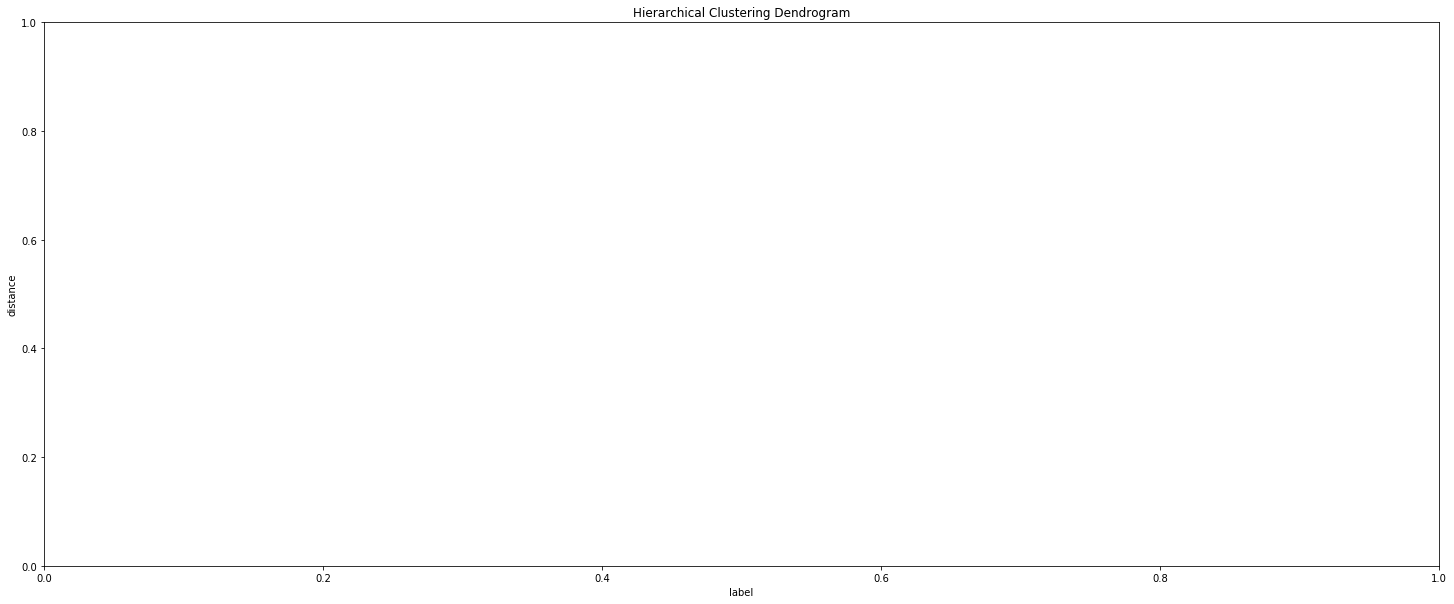

In [19]:
import sys
sys.setrecursionlimit(10000)

# Calculate the linkage: mergings
mergings = linkage(X, method='ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('label')
plt.ylabel('distance')

max_d = .6

# Plot the dendrogram, using varieties as labels
dendrogram(mergings,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=12,  # show only the last p merged clusters
           show_leaf_counts=True,  # otherwise numbers in brackets are counts
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True,  # to get a distribution impression in truncated branches
#            annotate_above=.4,
#            max_d=max_d
        )
plt.show()

#### Dimensionality Reduction

In [ ]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(X)



# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


pca = PCA(n_components=2)

pipeline = make_pipeline(scaler, pca)

# Fit the PCA instance to the scaled samples
pipeline.fit(X)

# Transform the scaled samples: pca_features
pca_features = pipeline.transform(X)

# Print the shape of pca_features
print(pca_features.shape)


In [ ]:
# would run pca features through supervised learning. black box, but works well possibly in terms of prediction

#### Unsupervised Learning for Text Analysis

In [ ]:
df_with_text = df_with_less_text[(df_with_less_text.text_parse.notnull()) & (df_with_less_text.qualified.notnull())].copy()

In [ ]:
# Perform the necessary imports
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Create a pipeline: pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=50)),
    ('kmeans', KMeans(n_clusters=3)),
])

X_train, X_test, y_train, y_test = train_test_split(df_with_text.text_parse, df_with_text.qualified, test_size=0.3, random_state=42)

# Fit the pipeline to articles
pipeline.fit(X_train)

# Calculate the cluster labels: labels
labels = pipeline.predict(X_train)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({ 'label': labels, 'article': y_train })

ct = pd.crosstab(df['label'], df['article'])

print(ct)

